In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import math
from IPython.display import display
from matplotlib import pyplot as plt

In [7]:
# 產業
occupation_dict = {
    1: "營造／礦砂業",
    2: "製造業",
    3: "水電燃氣業",
    4: "批發／零售／貿易商",
    5: "旅宿／餐飲",
    6: "運輸倉儲",
    7: "農／林／漁／牧",
    8: "金融保險",
    9: "不動產／租賃",
    10: "軍／警／消",
    11: "公務人員",
    12: "律師／會計師／地政士",
    13: "醫藥服務",
    14: "休閒服務",
    15: "其他／家管",
    16: "自由業",
    17: "投資／自營商",
    18: "媒體文教",
    19: "學生",
    20: "學校教師（含行政人員）",
    21: "資訊科技",
    22: "公證人或記帳士",
    23: "國防工業",
    24: "投資或稅務顧問公司",
    25: "不動產仲介／代銷商",
    26: "大宗物資貿易商",
    27: "博弈業（網路／實體）",
    28: "八大特種行業",
    29: "宗教、慈善、基金會",
    30: "銀樓、珠寶商",
    31: "藝術品或古董買賣商",
    32: "當鋪",
    33: "實體或虛擬貨幣兌換所"
}

In [8]:
def f(a, b):
    if math.isnan(b):
        return a
    else:
        return min(a, b)

In [9]:
def to_class(x):
    '''
    0~10萬
    10~30萬(不含10萬)
    30~50萬(不含30萬)
    50~100萬(不含50萬)
    '''
    if x < 1E5:
        return 0
    if 1E5 <= x and x < 3E5:
        return 1
    if 3E5 <= x and x < 5E5:
        return 2
    else:
        return 3

In [10]:
# 玉山資料
yushan = pd.read_csv('./data/job.csv')
yushan['job_title'] = yushan['job_title'].apply(lambda x: str(x).strip())
yushan = yushan[yushan['quota_now']<=1e6] # consider quota in [0, 1E6], endpoints included
yushan['y_num'] = yushan[['quota_now', 'quota_now_elec']].apply(lambda x: f(*x), axis=1)
yushan['y_cat'] = yushan['y_num'].apply(lambda x: to_class(x))
yushan = yushan.drop(['quota_origin_elec', 'quota_now_elec', 'quota_origin', 'quota_now'], axis=1)
yushan = yushan[yushan['occupation'] <= 33]
yushan = yushan.dropna()
display(yushan.head())

,job_title,occupation,y_num,y_cat
0,維護工程師,21.0,500000.0,3
1,攝影記者,18.0,300000.0,2
3,工程師,2.0,300000.0,2
4,高級工程師,2.0,300000.0,2
5,業務,21.0,1000000.0,3


In [11]:
yushan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129117 entries, 0 to 131468
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   job_title   129117 non-null  object 
 1   occupation  129117 non-null  float64
 2   y_num       129117 non-null  float64
 3   y_cat       129117 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 4.9+ MB


<AxesSubplot:>

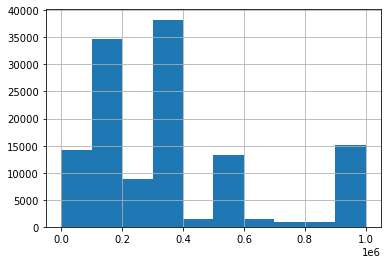

In [12]:
yushan['y_num'].hist()

<AxesSubplot:>

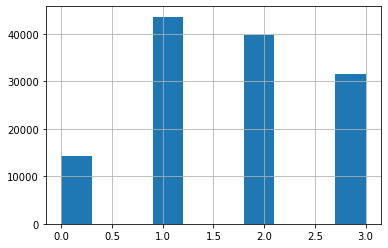

In [13]:
yushan['y_cat'].hist()

<AxesSubplot:>

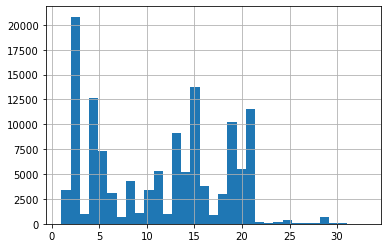

In [14]:
yushan['occupation'].hist(bins=33)

/home/jack/miniconda3/envs/ml/lib/python3.9/site-packages/pandas/plotting/_matplotlib/hist.py:396: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


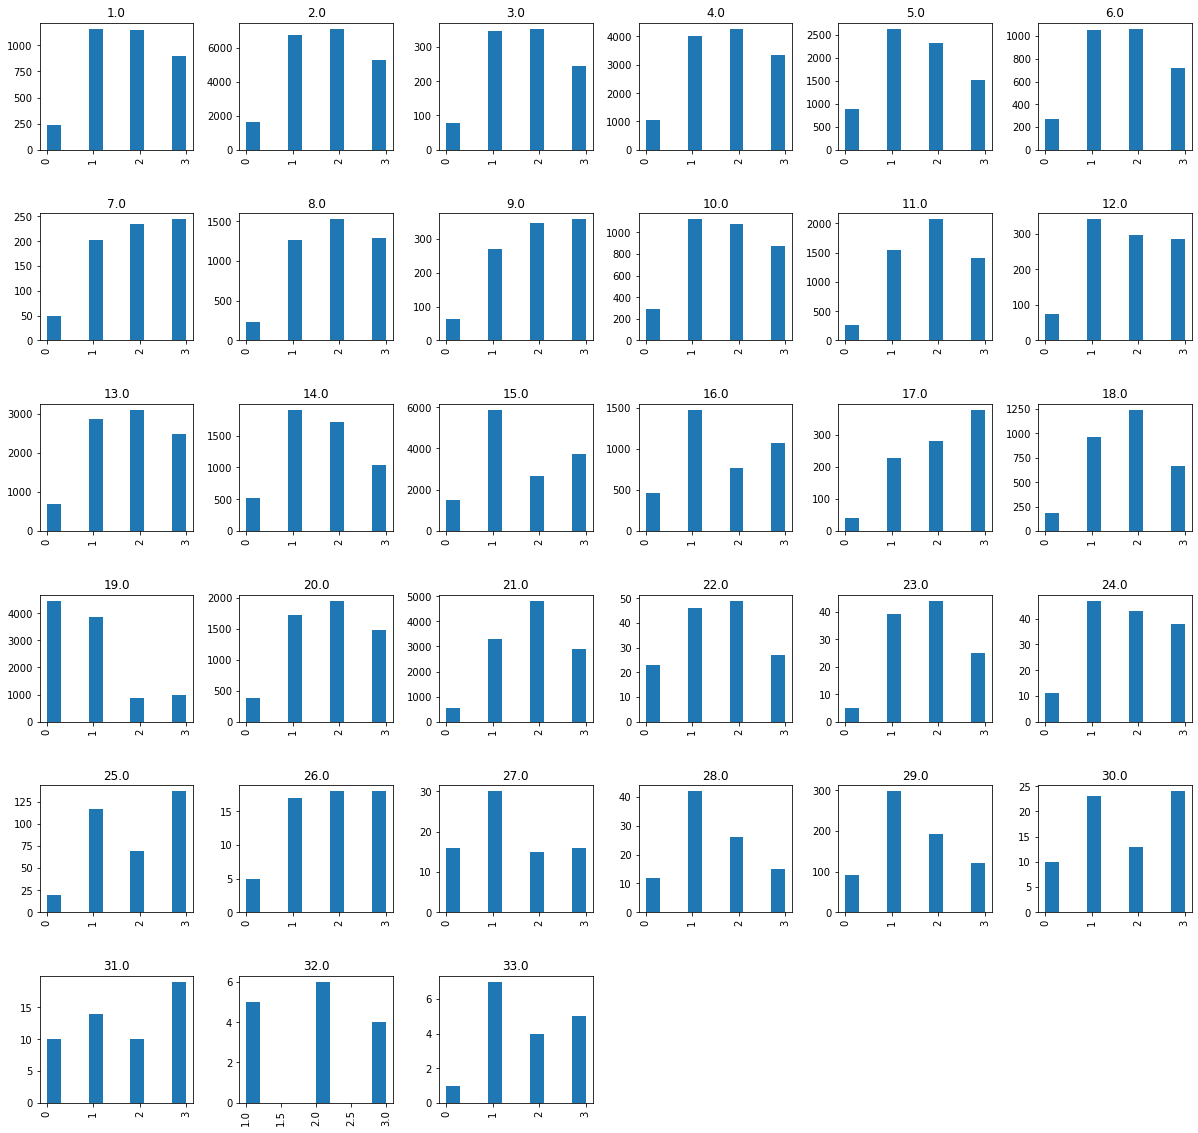

In [15]:
fig, ax = plt.subplots(figsize=(20, 20))
yushan.hist(column='y_cat', by='occupation', ax=ax)
plt.show()
plt.close()

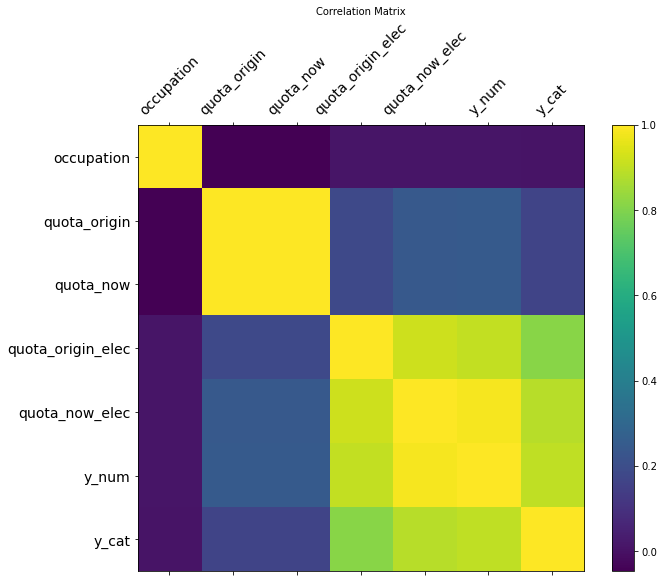

In [16]:
mini_yushan = yushan.dropna()
mini_yushan = mini_yushan.loc[(mini_yushan != 0).all(axis=1)]
# mini_yushan = mini_yushan[mini_yushan['occupation']==6.0]

corr = mini_yushan.corr('pearson')
f = plt.figure(figsize=(10, 8))
plt.matshow(mini_yushan.corr(), fignum=f.number)
plt.xticks(range(mini_yushan.select_dtypes(['number']).shape[1]), mini_yushan.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(mini_yushan.select_dtypes(['number']).shape[1]), mini_yushan.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=10)
plt.show()
plt.close()

In [ ]:
# 勞動部資料
gov = pd.read_excel('./data/psdnquery1.xlsx')
display(gov.head())

In [5]:
# 各職業平均薪水
raw_salary = gov['各業受僱員工(總薪資)(109年7月)(單位：元)'].values
salary_list = []
for x in raw_salary:
    x = str(x)
    x = re.sub(r'[^\w]', '', x)
    x = re.compile(u'[\u4E00-\u9FA5|\s]').findall(x)
    x = "".join(x)
    if x:
        salary_list.append(x)
    else:
        salary_list.append('無')
        
print(salary_list[:10])

['無', '無', '總計', '主管及監督人員', '高階主管總經理及總執行長', '中階主管經理', '監督人員含現場及辦公室主任科股長', '專業人員', '物理化學及地球科學專業人員', '精算師取得正式資格者']


In [52]:
job_list = yushan['job_title'].values
job_list[:10]


array(['維護工程師', '工程師', '高級工程師', '主任', 'OP', '行政助理', '專案經理', '學生', '護理師',
       '兼職'], dtype=object)

In [53]:
def get_features(job_title, statistics=None):
    
    assert statistics is not None
    
    global salary_list
    global gov
    
    if job_title == '無':
        return 0
    if job_title is None:
        return 0
    
    score_list = []
    for x in salary_list[2:]:
        score_list.append(nltk.edit_distance(list(job_title), list(x)))
    idx_list = np.argsort(score_list)
    
    subidx = 0
    while True:
        res = []    
        for x in gov.iloc[idx_list[subidx], :].values:
            if isinstance(x, str):
                x = x.replace(',', '')
                if x.isdigit():
                    res.append(int(x))
        if len(res) > 0:
            if statistics == 'mean':
                return np.mean(res)
            if statistics == 'median':
                return np.median(res)
            if statistics == 'std':
                return np.std(res)
        subidx += 1

In [12]:
# activate me if necessary

# from tqdm import tqdm
# salary_median = []
# for x in tqdm(yushan['job_title']):
#     salary_median.append(get_features(x, 'std')) # choose your statistics here
    
# print(len(yushan['job_title']))
# print(sum(np.array(salary_median) == 0))
# yushan['salary_std'] = salary_median
# yushan.to_csv('./data/job_extened.csv', index=None)

# Exploration

In [71]:
yushan = pd.read_csv('./data/job_extened.csv')
yushan = yushan[yushan['quota_now']<=1e6]
yushan['y_num'] = yushan[['quota_now', 'quota_now_elec']].apply(lambda x: f(*x), axis=1)

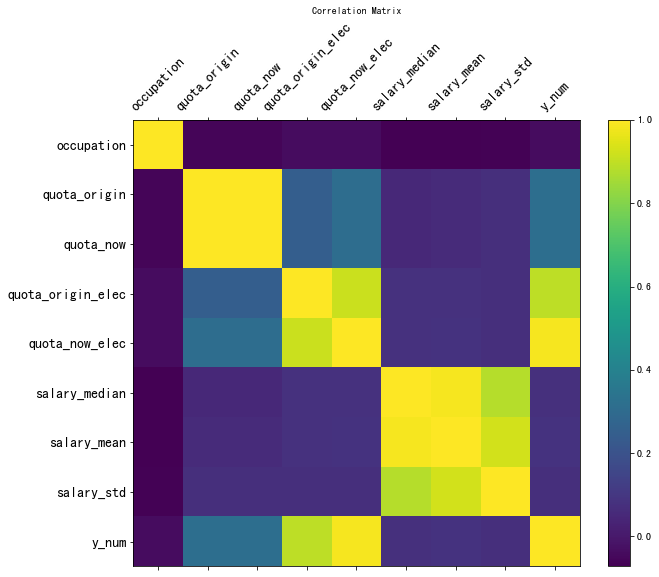

In [72]:
mini_yushan = yushan.dropna()
mini_yushan = mini_yushan.loc[(mini_yushan != 0).all(axis=1)]
# mini_yushan = mini_yushan[mini_yushan['occupation']==6.0]

corr = mini_yushan.corr('pearson')
f = plt.figure(figsize=(10, 8))
plt.matshow(mini_yushan.corr(), fignum=f.number)
plt.xticks(range(mini_yushan.select_dtypes(['number']).shape[1]), mini_yushan.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(mini_yushan.select_dtypes(['number']).shape[1]), mini_yushan.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=10)
plt.show()
plt.close()

In [131]:
from sklearn.model_selection import train_test_split
yushan = yushan.dropna()
X=yushan[['occupation', 'salary_median', 'salary_mean', 'salary_std']] # Features
y=yushan['y_cat']  # Labels

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5857775318206973


(array([ 1154., 15043.,     0.,  1953.,  1935.,   158.,  2323.,   202.,
           87.,  2440.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

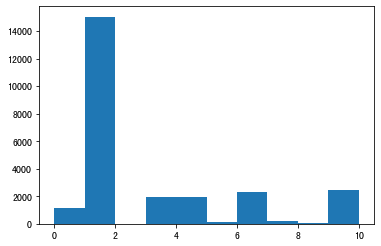

In [136]:
plt.hist(y_train)